In [1]:
%load_ext autoreload
%autoreload 2
import mmcv
from mmdet3d.apis import inference_mono_3d_detector, init_model
from mmdet3d.registry import VISUALIZERS
from mmengine import load, dump
from mmdet3d.registry import VISUALIZERS
import cv2
import numpy as np
import sys
from sensus.tools.new_visualizer import draw_monodetection_labels, draw_monodetection_results
from sensus.tools.data_processor_old import DataProcessor
import pickle
from sensus.tools.data_processor import SensusInstance

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import cos, sin, pi, radians, degrees

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
# Create pkl file for inference
def create_pkl(file_name, calib_file, cam_type = 'CAM_BACK', pkl_path = 'data.pkl'):
    # Get the camera to image matrix
    array = DataProcessor(None, calib_file).process_calib_file()['P2']

    # Remove the last 3 elements of the array
    indices_to_remove = [3, 7, 11]
    array = [array[i] for i in range(len(array)) if i not in indices_to_remove]

    # Reshape the array into a 3x3 matrix
    cam2img = [array[i:i+3] for i in range(0, len(array), 3)]

    # Create the data dictionary
    data = [{'images': {cam_type: {'img_path': f'{file_name}.png', 'cam2img': cam2img}}}]

    # Save data to the pkl file
    with open(pkl_path, "wb") as file:
        pickle.dump(data, file)

def draw_bev_bboxes(bboxes, labels, output_filename, cars_index = 0, line_width=2, alpha=0.7, save=True):
    """
    Draws a BEV of bounding boxes and saves the figure as an image.

    Parameters:
    - bboxes: A list of bounding boxes, each defined as a dictionary with keys
              'location', 'dimensions', 'rotation_y', and 'score'.
    - labels: A list of bounding boxes, each defined as a dictionary with keys
    - output_filename: Filename to save the BEV image.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.set_aspect('equal')
    ax.set_xlim(-50, 50)
    ax.set_ylim(0, 140)

    for bbox in bboxes:
        x, y, z = bbox.location
        length, width, height = bbox.dimensions
        rotation_y = bbox.rotation_y
        if bbox.type == 'Car' or bbox.type == cars_index:
            # Calculate the bottom-left corner as the starting point
            bottom_left_x = x - (width / 2)
            bottom_left_z = z - (length / 2)

            # Create a rectangle 
            rect = patches.Rectangle(
                (bottom_left_x, bottom_left_z), width, length, linewidth=line_width, 
                edgecolor='blue', facecolor='none', alpha=alpha)

            # Apply the rotation transformation to the rectangle
            t = patches.transforms.Affine2D().rotate_around(x, z, -rotation_y-np.pi/2) + ax.transData

            rect.set_transform(t)
            ax.add_patch(rect)
    
    for bbox in labels:
        x, y, z = bbox.location
        length, width, height = bbox.dimensions
        rotation_y = bbox.rotation_y
        if bbox.type == 'Car' or bbox.type == 0:
            # Calculate the bottom-left corner as the starting point
            bottom_left_x = x - (width / 2)
            bottom_left_z = z - (length / 2)

            # Create a rectangle patch with the specified line width, not filled, and rotated around the center
            rect = patches.Rectangle(
                (bottom_left_x, bottom_left_z), width, length, linewidth=line_width, 
                edgecolor='red', facecolor='none', alpha=alpha)

            # Apply the rotation transformation to the rectangle
            t = patches.transforms.Affine2D().rotate_around(x, z, -rotation_y-np.pi/2) + ax.transData

            rect.set_transform(t)
            ax.add_patch(rect)

    # Create legend for the colors used
    blue_patch = patches.Patch(color='blue', label='Results')
    red_patch = patches.Patch(color='red', label='Labels')
    plt.legend(handles=[blue_patch, red_patch], fontsize='large')

    plt.xlabel('X Position (meters)')
    plt.ylabel('Z Position (meters)')
    plt.title('Bird\'s Eye View of Detected Objects')
    plt.grid(True)
    if save:
        plt.savefig(output_filename + '.png')


In [3]:
file = '000000'
dataset = 'dair'
if dataset == 'kitti':
    img_file = '/home/javier/datasets/kitti/training/image_2/' + file + '.png'
    labels_file = '/home/javier/datasets/kitti/training/label_2/'+ file + '.txt'
    calib_file = '/home/javier/datasets/kitti/training/calib/'+ file + '.txt'
    pitch = 0.0
elif dataset == 'dair':
    img_file = '/home/javier/datasets/DAIR-V2X/single-infrastructure-side-mmdet/training/image_2/' + file + '.png'
    labels_file = '/home/javier/datasets/DAIR-V2X/single-infrastructure-side-mmdet/training/label_2/'+ file + '.txt'
    calib_file = '/home/javier/datasets/DAIR-V2X/single-infrastructure-side-mmdet/training/calib/'+ file + '.txt'
    pitch = 0.2031

ann_file = '/home/javier/sensus-loci/paper_alvaro/data.pkl'
cam_type = 'CAM_BACK'

## Inference

In [4]:
create_pkl(file, calib_file, cam_type, ann_file)

# Select model pgd if pdg
model = 'pgd'

if model == 'monocon':
    config_file = '/home/javier/sensus-loci/work_dirs/paper/monocon/sensus_config.py'
    checkpoint_file = '/home/javier/sensus-loci/work_dirs/paper/monocon/epoch_100.pth'
elif model == 'smoke':
    config_file = '/home/javier/sensus-loci/work_dirs/paper/smoke_dla34_dlaneck_gn-all_4xb8-6x_dair-mono3d/smoke_dla34_dlaneck_gn-all_4xb8-6x_dair-mono3d.py'
    checkpoint_file = '/home/javier/sensus-loci/work_dirs/paper/smoke_dla34_dlaneck_gn-all_4xb8-6x_dair-mono3d/epoch_100.pth'
elif model == 'pgd':
    config_file = '/home/javier/sensus-loci/work_dirs/pgd_r101-caffe_fpn_head-gn_4xb3-4x_dair-mono3d/pgd_r101-caffe_fpn_head-gn_4xb3-4x_dair-mono3d.py'
    checkpoint_file = '/home/javier/sensus-loci/work_dirs/pgd_r101-caffe_fpn_head-gn_4xb3-4x_dair-mono3d/epoch_48.pth'

device = 'cuda:1'
model_mmdet = init_model(config_file, checkpoint_file, device=device)
result = inference_mono_3d_detector(model_mmdet, img_file, ann_file, cam_type)

# init visualizer
visualizer_mmdet = VISUALIZERS.build(model_mmdet.cfg.visualizer)
visualizer_mmdet.dataset_meta = model_mmdet.dataset_meta

Loads checkpoint by local backend from path: /home/javier/sensus-loci/work_dirs/pgd_r101-caffe_fpn_head-gn_4xb3-4x_dair-mono3d/epoch_48.pth
04/05 00:26:22 - mmengine - INFO - ModulatedDeformConvPack bbox_head.cls_convs.1.conv is upgraded to version 2.
04/05 00:26:22 - mmengine - INFO - ModulatedDeformConvPack bbox_head.reg_convs.1.conv is upgraded to version 2.


/home/javier/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/javier/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [5]:
print(result.pred_instances_3d)

<InstanceData(

    META INFORMATION

    DATA FIELDS
    labels_3d: tensor([2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
               device='cuda:1')
    bboxes_3d: CameraInstance3DBoxes(
            tensor([[ -5.0871,   2.9956,  19.3999,   4.3576,   1.4572,   2.0485,   4.7553],
                [ -1.9743,   1.6950,  25.2627,   4.2898,   1.5940,   1.9019,   4.7285],
                [-20.1651,  -5.8900,  58.2315,   4.3514,   1.7624,   1.9750,   1.5911],
                [  4.7648,   1.7186,  25.5844,   4.2909,   1.5950,   1.9310,   4.7475],
                [-16.5970,  -6.3936,  60.2705,   4.4969,   1.9686,   1.9692,   1.5961],
                [-16.5031,  -2.9202,  45.3415,   4.5285,   1.5408,   1.9161,   1.6111],
                [-16.8625, -10.1688,  76.7836,   4.2565,   1.6219,   1.9140,   1.5898],
                [  0.9995,  -4.5099,  52.5118,   4.2273,   1.5598,   1.7687,   4.7195],
                [ 15.5048,  -4.7688,  54.4027,   1.7457,   1.7322,   0.6986,   3.285

## Viz data

In [12]:
result_data = SensusInstance()
result_data.load_bboxes_from_result(result, cam_bbox=True, lidar_bbox=False)

labels_data = SensusInstance()
labels_data.load_bboxes_from_labels(labels_file, cam_bbox=True, lidar_bbox=False)

cars_index = 2

In [17]:
save_dir_img = 'result_%s_img' % model

draw_monodetection_results(img_file, calib_file, result, score=0.01, thickness=2, out_path=save_dir_img, index_car = cars_index)

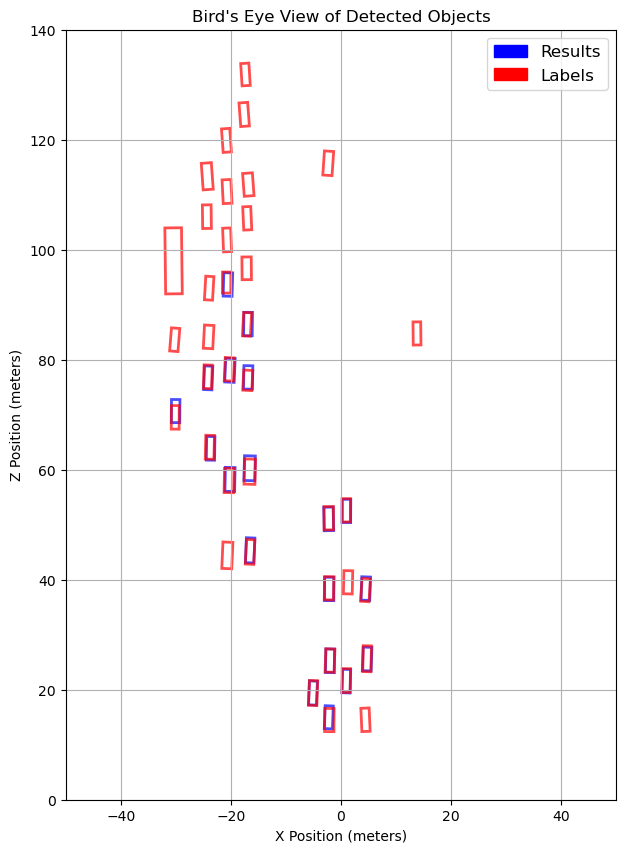

In [18]:
save_dir_bev = 'result_%s_bev' % model

draw_bev_bboxes(result_data.camera_bboxes, labels_data.camera_bboxes, output_filename=save_dir_bev, cars_index = cars_index, save=True)

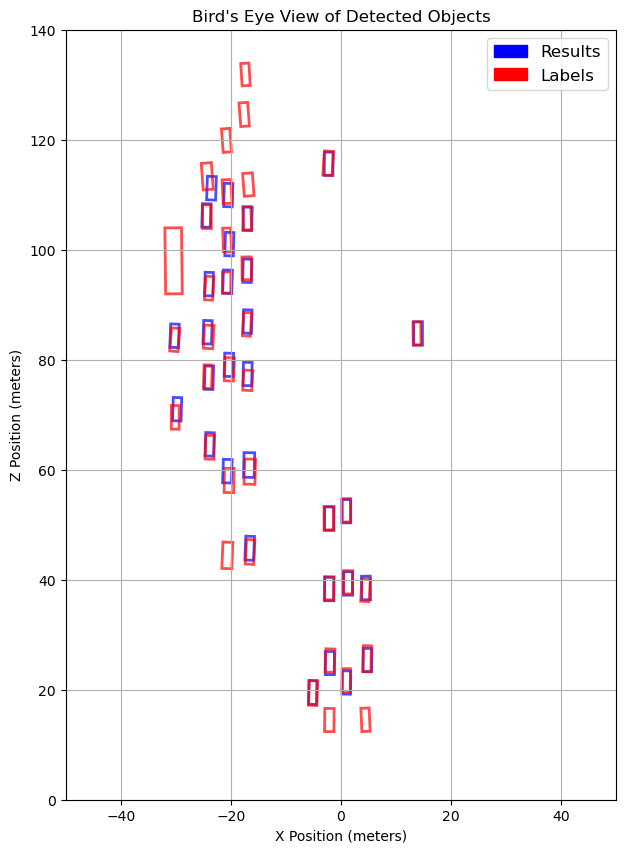

In [ ]:
save_dir_bev = 'result_%s_bev' % model

draw_bev_bboxes(result_data.camera_bboxes, labels_data.camera_bboxes, output_filename=save_dir_bev, cars_index = cars_index, save=True)